In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Count of images in each set

Number of images in train folder: 12601
Number of images in test folder: 5410


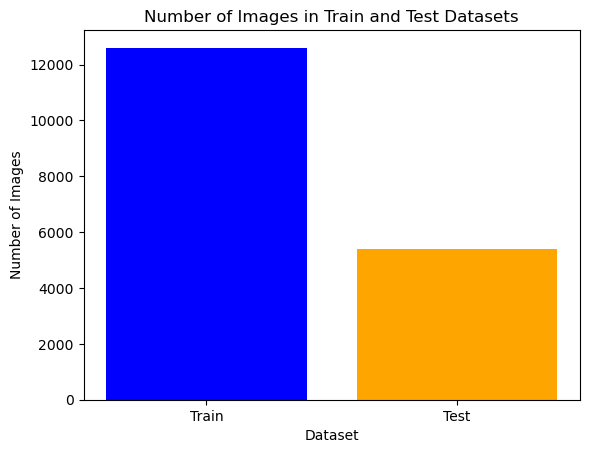

In [2]:

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                count += 1
    return count

# Define the paths to the train and test folders
train_folder_path = 'Human Action Recognition/train'
test_folder_path = 'Human Action Recognition/test'

# Count the images in each folder
train_image_count = count_images_in_folder(train_folder_path)
test_image_count = count_images_in_folder(test_folder_path)

# Print the counts
print(f'Number of images in train folder: {train_image_count}')
print(f'Number of images in test folder: {test_image_count}')

# Plotting the bar graph
labels = ['Train', 'Test']
counts = [train_image_count, test_image_count]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train and Test Datasets')
plt.show()


### Copying the images and splitting based on class

In [3]:
# Configuration
csv_file_path = 'Human Action Recognition/Training_set.csv'  # Update with your CSV file path
base_directory = './Label-dataset/train'  # Update with your base directory path
images_directory = 'Human Action Recognition/train'  # Update with your images directory path

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Get unique labels
labels = df['label'].unique()

# Create directories for each label
for label in labels:
    label_dir = os.path.join(base_directory, str(label))
    os.makedirs(label_dir, exist_ok=True)

# Copy files to corresponding directories with progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Copying files"):
    file_name = row['filename']
    label = row['label']
    
    # Define the source and destination paths
    src_path = os.path.join(images_directory, file_name)
    dst_path = os.path.join(base_directory, str(label), file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"File {src_path} does not exist.")


Copying files: 100%|████████████████████████████████████████████████████████████| 12600/12600 [01:37<00:00, 129.11it/s]


### Distribution of Classes in train dataset

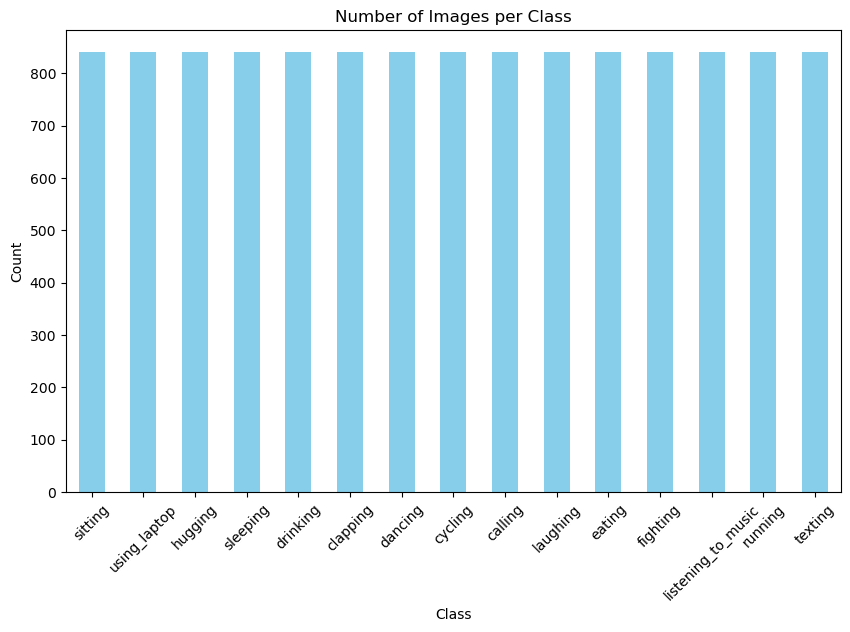

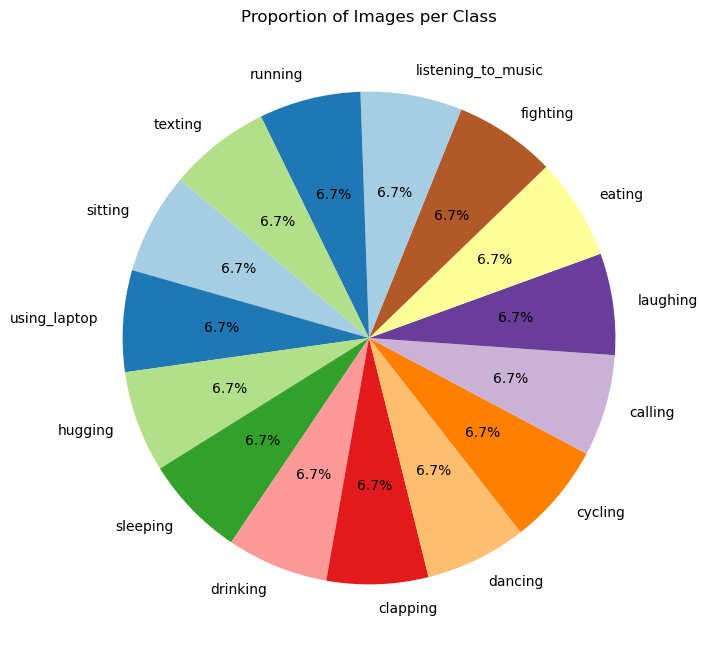

In [4]:
label_counts = df['label'].value_counts()

# Plot Bar Graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Proportion of Images per Class')
plt.ylabel('')  # Hides the 'y' label
plt.show()

#### Data preprocessing: Data augumentation

Found 10080 images belonging to 15 classes.
Found 2520 images belonging to 15 classes.


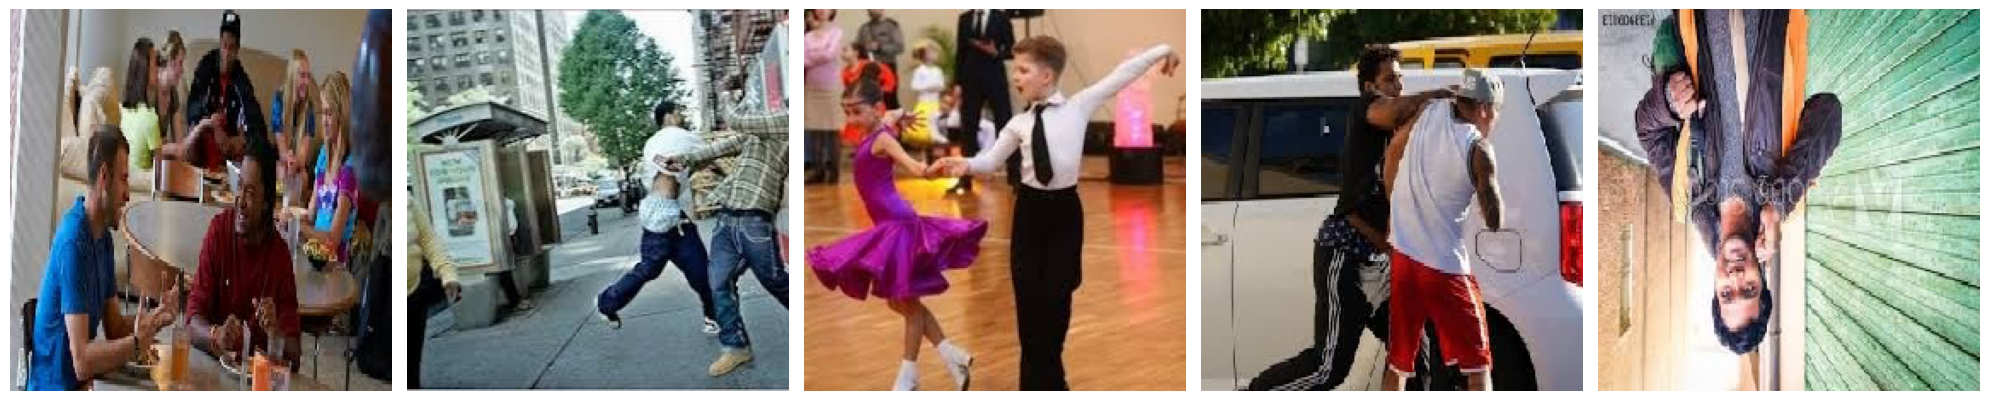

In [5]:
# Configuration
base_directory = './Label-dataset/train'  # The base directory where the images are stored

# Create an instance of ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    validation_split=0.2,  # Use 20% of the data for validation
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True  # Randomly flip images vertically
)

# Create a data generator for the training set
train_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images to 256x256 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    color_mode='rgb',  # Images are in RGB format
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    subset='training'  # Set as training data
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images to 256x256 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    color_mode='rgb',  # Images are in RGB format
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    subset='validation'  # Set as validation data
)

# Example of how to iterate through the training generator and plot images
images, labels = next(train_generator)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(images[:5], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


### Data preprocessing: Implement Alphapose  
#### needs to be done

### Buliding Simple CNN model

In [6]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # You can adjust the number of epochs
    verbose=1
)

Epoch 1/10
315/315 [==============================] - 94s 279ms/step - loss: 2.6298 - accuracy: 0.1392 - val_loss: 2.4114 - val_accuracy: 0.2242
Epoch 2/10
315/315 [==============================] - 31s 100ms/step - loss: 2.3430 - accuracy: 0.2459 - val_loss: 2.3335 - val_accuracy: 0.2536
Epoch 3/10
315/315 [==============================] - 32s 100ms/step - loss: 2.1374 - accuracy: 0.3054 - val_loss: 2.2661 - val_accuracy: 0.2806
Epoch 4/10
315/315 [==============================] - 31s 100ms/step - loss: 1.9434 - accuracy: 0.3783 - val_loss: 2.1398 - val_accuracy: 0.3143
Epoch 5/10
315/315 [==============================] - 31s 99ms/step - loss: 1.7485 - accuracy: 0.4506 - val_loss: 2.2611 - val_accuracy: 0.3032
Epoch 6/10
315/315 [==============================] - 31s 99ms/step - loss: 1.5207 - accuracy: 0.5312 - val_loss: 2.2967 - val_accuracy: 0.3004
Epoch 7/10
315/315 [==============================] - 31s 99ms/step - loss: 1.3131 - accuracy: 0.6063 - val_loss: 2.2989 - val_accur

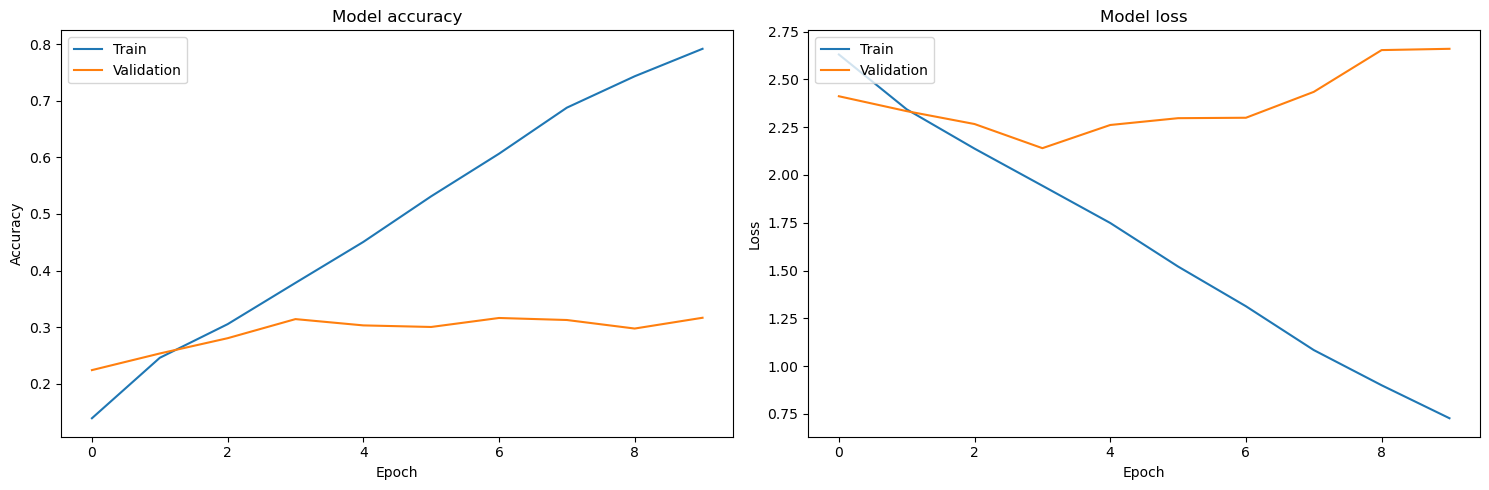

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Building MobilenetV2 model

In [8]:


# Load the MobileNetV2 model with pre-trained weights, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # You can adjust the number of epochs
    verbose=1
)

Epoch 1/10
315/315 [==============================] - 21s 60ms/step - loss: 1.6661 - accuracy: 0.4612 - val_loss: 1.4387 - val_accuracy: 0.5337
Epoch 2/10
315/315 [==============================] - 18s 58ms/step - loss: 1.3539 - accuracy: 0.5567 - val_loss: 1.3733 - val_accuracy: 0.5536
Epoch 3/10
315/315 [==============================] - 18s 58ms/step - loss: 1.2377 - accuracy: 0.5914 - val_loss: 1.3898 - val_accuracy: 0.5512
Epoch 4/10
315/315 [==============================] - 18s 58ms/step - loss: 1.1568 - accuracy: 0.6213 - val_loss: 1.2734 - val_accuracy: 0.5806
Epoch 5/10
315/315 [==============================] - 18s 57ms/step - loss: 1.0883 - accuracy: 0.6415 - val_loss: 1.3651 - val_accuracy: 0.5639
Epoch 6/10
315/315 [==============================] - 18s 57ms/step - loss: 1.0250 - accuracy: 0.6657 - val_loss: 1.2943 - val_accuracy: 0.5806
Epoch 7/10
315/315 [==============================] - 18s 58ms/step - loss: 0.9580 - accuracy: 0.6812 - val_loss: 1.3056 - val_accuracy:

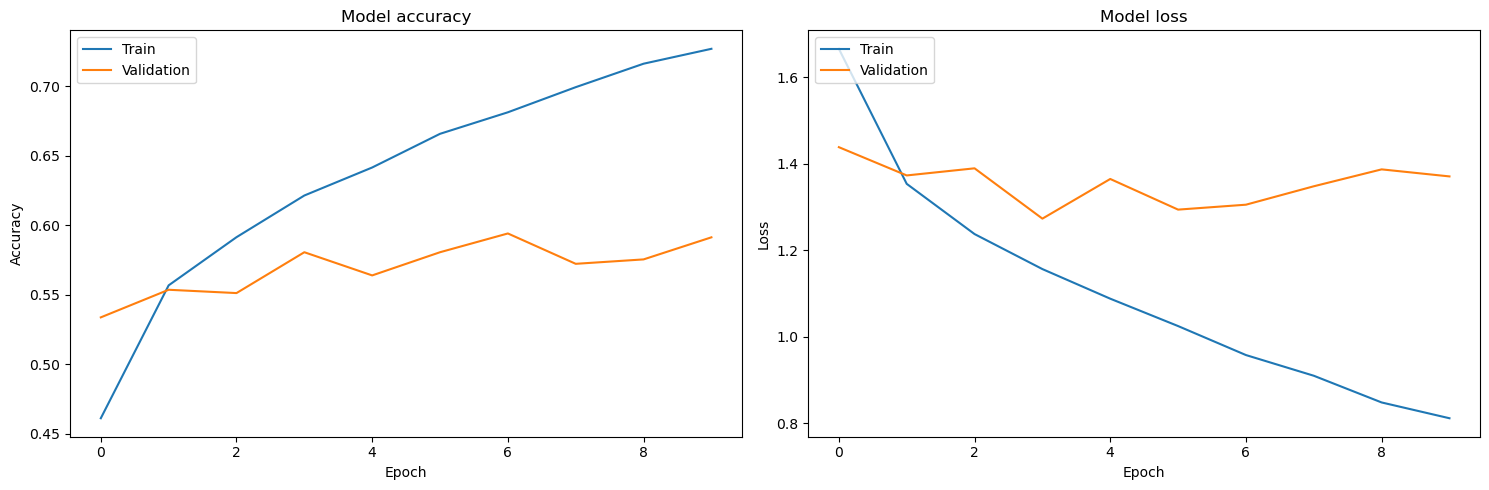

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()